# Relatório e Projeto - Sistema de indexação e busca de documentos

## 1 - Informações da equipe
---
IN1152 - Recuperação Inteligente de Informação - 2022.2

**Equipe**: Matheus Rodrigues de Souza Félix (matheusrdgsf@gmail.com) e Rodrigo Souza de Melo (rsm5@cin.ufpe.br)

**Projeto "Sistema de indexação e busca de documentos"**

Professora Flavia de Almeida Barros (fab@cin.ufpe.br)

- Este relatório apresentará as seções solicitadas no Trabalho 1 - Sistema de indexação e busca de documentos. E mais abaixo o código-fonte do projeto

---

## 2 - Descrição dos documentos (corpus) que serão indexados pelo sistema
---

 - 2 Temas/tópicos dos documentos da sua base
 - Mostrar no relatório 2 ou 3 exemplos de documentos do corpus
 
 - O 20 newsgroups dataset [1] compreende cerca de 18.000 posts de newsgroups em 20 tópicos (temas) divididos em dois subconjuntos, sendo um para treinamento (ou desenvolvimento) e outro para teste (ou avaliação de desempenho).
 - Utilizamos 2 tópicos(temas) do subconjunto de treinamento para o nosso sistema de indexação e busca de documentos. São eles: alt.atheism (altheism - ateísmo) e soc.religion.christian (christian - cristianismo)
 - Conforme a Figura 1 abaixo, neste dataset temos 480 documentos com tema ateísmo e 599 cristianismo.
 <br>
 
 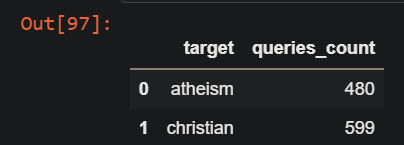
 <center><b>Figura 1: Tamanho do Dataset</b></center>
 <br>

 - Realizamos a rotulação da relevância em parte do dataset com base na querie Q1: "Rational proof of jesus not exists" (buscando ser similar a ateísmo) e Q2: "Moral and ethics in christianism" (buscando ser similar a cristianismo). Devido a isso, ficamos impossibilitados de realizar o cálculo da cobertura desta base de documentos, todavia, apresentaremos a  precisão e a f-measure.
 
 - Dataset: Formando pelos elementos abaixo.
   - corpus: Representa o título e o texto do documento
   - query: Representa a consulta
   - qrels: Representa a relevância das consulta(s) realizada(s)
   - _id: Id do documento
   - text: Texto do documento
   - target: Tema do documento - altheism ou christian
   - q1: Relevância da querie 1 em relação ao texto do documento. Onde tem-se o valor 1 para relevante e 0 para não.
   - q2: Relevância da querie 2 em relação ao texto do documento. Onde tem-se o valor 1 para relevante e 0 para não.
   
 - Na figura 2 abaixo, temos um exemplo de uma estrutura com 2 documentos e as relevâncias de cada consulta q1 e q2 [2].
<br>
 
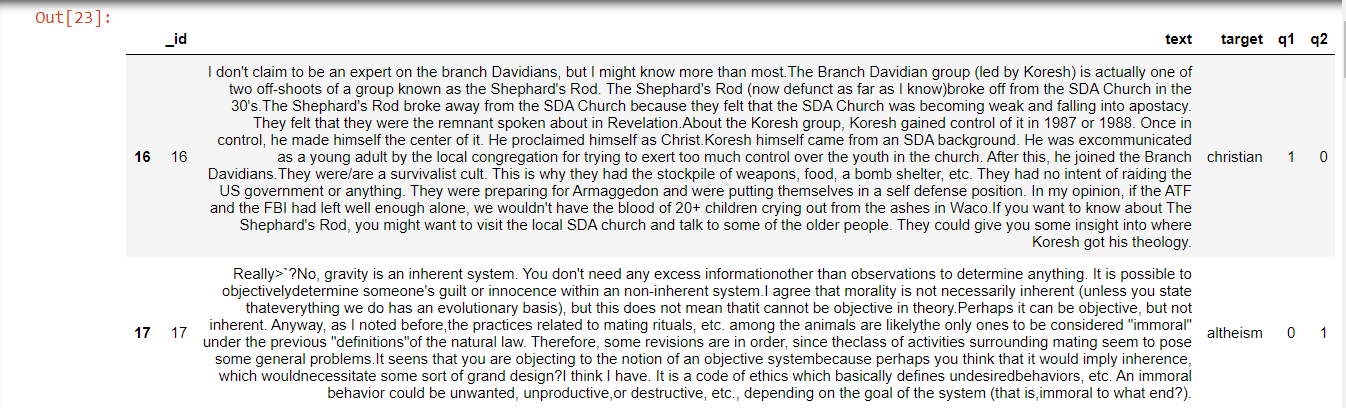
<center><b>Figura 2: Exemplo de estrutura do documento</b></center>
 <br>
 
 Referências: 
 * [1] https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html
 * [2] https://github.com/MatheusRDG/information-retrieval-cin-2022/blob/dev/information-retrieval-project.ipynb
---

## 3 - Arquitetura do sistema 
---

- Prover uma descrição breve das etapas de processamento do sistema construído com base na ferramenta escolhida. Informar qual é o modelo de RI implementado pelo seu sistema, qual a fórmula para cálculo dos pesos e qual a função de ranking (vejam as aulas de modelos de RI). 

Utilizamos o modelo de RI Booleano que possui pesos binários (1 ou 0) utilizando o NLTK (escrito em Pyhton) para recuperar os documentos por meio de filtragem. Para a criação das bases levamos em conta as técnicas abaixo: 
 - unicode (para remover os acentos)
 - punkt (Tokenizador Punkt para inglês.) 
 - stopwords (em inglês)
 - Tokenização (análise léxica)
 - Stemming (lematização)
 - stopwords (variedade de palavras numa determinada língua sem sentido semântico, com isso, facilita a remoção delas)
 - dicionário de sinônimos (tesauro) utilizando o wordnet
 
Também estamos utilizando o algoritmo de "força bruta" e a métrica é cosseno.

Fonte:
 - [1] https://pypi.org/project/Unidecode/
 - [2] https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html
 - [3 ps://docs.scipy.org/doc/scipy/reference/spatial.distance.html
 - [4] https://www.holisticseo.digital/python-seo/nltk/wordnet
---

## 4 - Criação das bases de documentos indexados 
---

- Preparação & Indexação dos documentos: O sistema deve criar, de forma automática, cinco BASES indexadas a partir da base original de documentos. Cada BASE (no Solr, são COREs) deve utilizar processos diferentes na preparação (pré-processamento) dos dados. O objetivo é verificar qual é a melhor configuração de pré-processamento para o seu caso.

   - BASE 1: documentos originais, sem nenhum pré-processamento extra (só tokenização);
   - BASE 2: apenas eliminar stopwords (usar filtro de stopwords);
   - BASE 3: apenas usar stemming, sem eliminar as stopwords (não usar filtro de stopwords);
   - BASE 4: eliminar stopwords (usar filtro de stopwords) e usar stemming;
   - BASE 5: eliminar stopwords (usar filtro de stopwords), não usar stemming, e usar dicionário de sinônimos.

Fontes: 
 - https://acervolima.com/como-obter-sinonimos-antonimos-de-nltk-wordnet-em-python/
 - https://www.holisticseo.digital/python-seo/nltk/wordnet
   
---


## 5 - Criação das consultas e Criação da Matriz de relevância  
---

- Prover uma descrição breve das etapas de processamento do sistema construído com base na ferramenta escolhida. Informar qual é o modelo de RI implementado pelo seu sistema, qual a fórmula para cálculo dos pesos e qual a função de ranking (vejam as aulas de modelos de RI). 

- Esta etapa foi descrita em mais detalhes na atividade correspondente, postada no Classroom. 
  ===> DÚVIDA: NÃO ENCONTREI OS DETALHES NO CLASSROOM.
  
- Mostrar aqui parte da matriz - basta mostrar as 5 colunas exemplificadas abaixo (incluindo a coluna final com a quantidade de documentos relevantes). 

Consultas (queries):
- Q1: "Rational proof of jesus not exists"
- Q2: "Moral and ethics in christianism"

Matriz de Relevância "Consultas x Documentos"
<br>
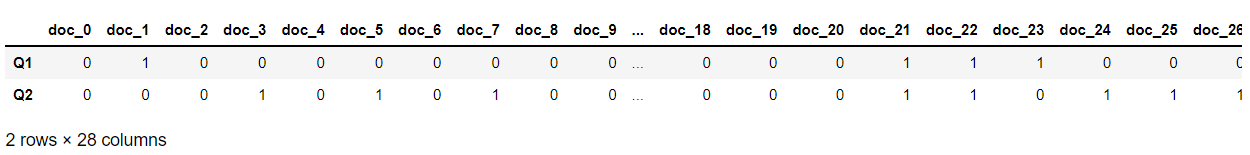
<center><b>Figura 3: Matriz de Relevância - parte 1</b></center>
<br>
 

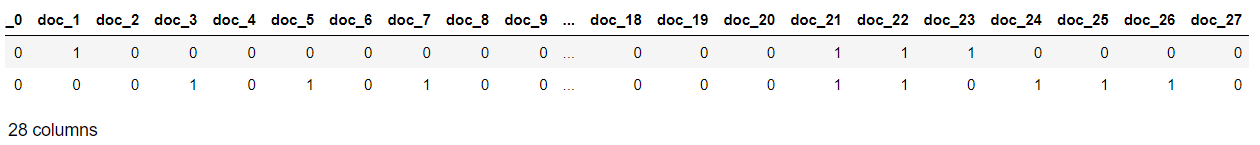
<center><b>Figura 4: Matriz de Relevância - parte 2</b></center>
 <br>
 
 




---

## 6 - Testes/Avaliação 
---

- Submeter as 2 consultas para cada BASE criada, e avaliar cada resultado separadamente -  i.e., calcular separadamente a precisão e a cobertura de cada consulta em relação a cada BASE criada. 
- Usar as fórmulas vistas em aula: precisão, cobertura e F-measure. 
- Incluir no relatório uma matriz de resultados para CADA consulta. Assim podemos ver a influência do pré-processamento dos documentos no resultado final do sistema.





Matriz de resultados para a Consulta 1
- Consulta: incluam aqui o texto da consulta avaliada nessa matriz
- Qtd de documentos relevantes: ver matriz de relevância (avaliação manual)

|  | **Precisão** | **Cobertura** | **F-measure** | **Qtd de Docs relevantes retornados pela  consulta 1** | **Qtd total de documentos retornados pela consulta 1** |
|:--------:|:------------:|:-------------:|:-------------:|:------------------------------------------------------:|:------------------------------------------------------:|
| BASE 1   |              |               |               |                                                        |                                                        |
| BASE 2   |              |               |               |                                                        |                                                        |
| BASE 3   |              |               |               |                                                        |                                                        |
| BASE 4   |              |               |               |                                                        |                                                        |
| BASE 5   |              |               |               |                                                        |                                                        |





Matriz de resultados para a Consulta 2
- Consulta: incluam aqui o texto da consulta avaliada nessa matriz
- Qtd de documentos relevantes: ver matriz de relevância (avaliação manual)

|  | **Precisão** | **Cobertura** | **F-measure** | **Qtd de Docs relevantes retornados pela  consulta 2** | **Qtd total de documentos retornados pela consulta 2** |
|:--------:|:------------:|:-------------:|:-------------:|:------------------------------------------------------:|:------------------------------------------------------:|
| BASE 1   |              |               |               |                                                        |                                                        |
| BASE 2   |              |               |               |                                                        |                                                        |
| BASE 3   |              |               |               |                                                        |                                                        |
| BASE 4   |              |               |               |                                                        |                                                        |
| BASE 5   |              |               |               |                                                        |                                                        |




Matriz de resultados para o Sistema
- As medidas de precisão, cobertura e F-meause do sistema serão obtidas calculando-se a média entre os resultados obtidos com cada consulta em relação a cada BASE criado.

<br>

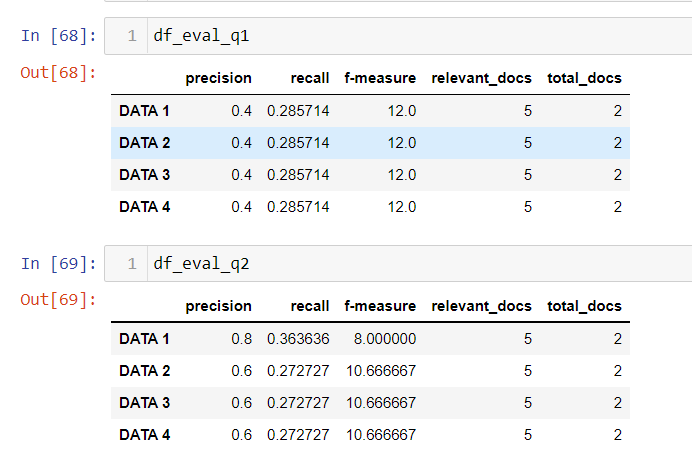

<center><b>Figura 5: Matriz de resultados para o Sistema</b></center>
 <br>


|        | Precisão média | Cobertura média | F-measure média |
|--------|----------------|-----------------|-----------------|
| BASE 1 |                |                 |                 |
| BASE 2 |                |                 |                 |
| BASE 3 |                |                 |                 |
| BASE 4 |                |                 |                 |
| BASE 5 |                |                 |                 |


---

 

## 7 - Conclusão 
---

- Deve conter um texto curto explicando o que vocês concluíram a partir do resultado dos testes (tabelas acima).

---

## Apresentação Oral
---
Apresentar a execução de UMA das duas consultas submetidas ao sistema:

- Explicar rapidamente sua participação no trabalho e como utilizou a ferramenta escolhida (2 pontos).
- Explicar a etapa de indexação de cada um dos índices invertidos (BASES) (3 pontos).
- Explicar como se deu o pré-processamento da consulta (2 pontos).
- Explicar os efeitos do pré-processamento de cada uma das BASES nos resultados obtidos com cada consulta (2 pontos).
- Responder a outras perguntas simples referentes ao trabalho (1 pontos).

---

## Código-fonte do projeto

### Configurações

In [1]:
#!pip install GitPython
#!pip install WordNet

### Libs

In [55]:
import os
import pandas as pd
from git import Repo
import gzip
from io import BytesIO
import gzip

from sklearn.metrics import confusion_matrix, classification_report #Utilizado para calcular a matrix de confusão e Relatório de classificação - Checar outra forma para remover o warning e não utilizar o parâmetro zero_division=1 no recall_score 

import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
import unidecode
import string
import re

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')

from sklearn.feature_extraction.text import TfidfVectorizer

from scipy import spatial
from sklearn.neighbors import NearestNeighbors as cosine_distance

from sklearn.metrics import precision_score, f1_score, recall_score

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Matheus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Matheus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Matheus\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Matheus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Data Collect Scifact

In [3]:
# DATA_PATH = "dataset/scifact-generated-queries"

In [4]:
# if not os.path.isdir(DATA_PATH):
#     Repo.clone_from("https://huggingface.co/datasets/BeIR/scifact-generated-queries", "dataset/scifact-generated-queries")

In [5]:
# with gzip.open(DATA_PATH+"/train.jsonl.gz", 'rb') as f:
#     file_content = f.read()

In [6]:
# dataset = pd.read_json(BytesIO(file_content), lines=True)

In [7]:
# dataset.groupby(["title"]).size().reset_index(name='queries_count')

### Data Collect 20News Labeled

In [2]:
DATA_PATH = "20news_labeled.csv"

In [4]:
pd.set_option('display.max_colwidth', None)
dataset = pd.read_csv(DATA_PATH)
dataset = dataset.dropna(how="any")

#TODO, Colocar os 230 documentos, mesmo que sem realizar o label, colocar pelo menos um valor default -> Alinhar com Matheus, qual valor Default seria.

## Pre-rocesing Data

In this step we will create 5 data models:

v1 - Only Tokenization; \
v2 - Only Stopword Filter; \
v3 - Only Stemming; \
v4 - Remove Stopwords and Stemming; \
v5 - Remove Stopworpd and expand words with Synonyms.


In [6]:
#import nltk
#nltk.download()
#nltk.download('wordnet')
#from nltk.corpus import wordnet

def remove_accent(text):
    return unidecode.unidecode(text)

def tokenize(text):
    return word_tokenize(text, language="english")

def pre_process(text, rmv_sw, stem, wordnet):    
    text_lower = text.lower()
    text_rmv_accent = remove_accent(text_lower)
    text_tokenized = tokenize(text_rmv_accent)
    text_rmv_alphanum = list(filter(lambda token: not re.search('\d', token), text_tokenized))
    text_final = list(filter(lambda token: token not in string.punctuation, text_rmv_alphanum))
    
    
    if rmv_sw:
        text_final = list(filter(lambda token: token not in STOPWORDS, text_final))
    
    if stem:
        stemmer = SnowballStemmer("english")
        text_final = list(map(lambda token: stemmer.stem(token), text_final))
    
    if wordnet:
        synonyms = []
        try:
            for token in text_final:
                synonyms+=list(map(lambda token: token.name(), wn.synsets(token)[0].lemmas()))
        except:
            pass
        
    return text_final

STOPWORDS = set(map(lambda token: remove_accent(token), stopwords.words("english")))

In [7]:
pre_process_v1 = lambda text: pre_process(text, False, False, False)
pre_process_v2 = lambda text: pre_process(text, True, False, False)
pre_process_v3 = lambda text: pre_process(text, False, True, False)
pre_process_v4 = lambda text: pre_process(text, True, True, False)
pre_process_v5 = lambda text: pre_process(text, True, True, True) # TODO: Para este caso eu chequei esta referência -> https://www.holisticseo.digital/python-seo/nltk/wordnet.

In [8]:
dataset_pcrs = dataset.copy().drop_duplicates()

In [9]:
dataset_pcrs["v1"] = dataset_pcrs["text"].apply(lambda text: pre_process_v1(text))

In [10]:
dataset_pcrs["v2"] = dataset_pcrs["text"].apply(lambda text: pre_process_v2(text))

In [11]:
dataset_pcrs["v3"] = dataset_pcrs["text"].apply(lambda text: pre_process_v3(text))

In [12]:
dataset_pcrs["v4"] = dataset_pcrs["text"].apply(lambda text: pre_process_v4(text))

In [13]:
# @TODO: Create Expand Vocabulary Pipeline add connect pre_process
dataset_pcrs["v5"] = dataset_pcrs["text"].apply(lambda text: pre_process_v5(text))

In [14]:
# Be careful with dataset_pcrs Len
#HTML(dataset_pcrs.head(3).to_html())

dataset_pcrs.head(2)

_id  \
0  880   
1  881   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

### Vectorizing Data

This step defines 5 (vectorizer, corpus_vetorized) models.

In [15]:
def get_documments(df_column):
    return list(map(lambda tokenized_text: " ".join(tokenized_text), df_column))

In [16]:
corpus_v1 = get_documments(dataset_pcrs["v1"])
corpus_v2 = get_documments(dataset_pcrs["v2"])
corpus_v3 = get_documments(dataset_pcrs["v3"])
corpus_v4 = get_documments(dataset_pcrs["v4"])
corpus_v5 = get_documments(dataset_pcrs["v5"])

In [17]:
vectorizer_v1 = TfidfVectorizer()
corpus_v1_vct = vectorizer_v1.fit_transform(corpus_v1)

vectorizer_v2 = TfidfVectorizer()
corpus_v2_vct = vectorizer_v2.fit_transform(corpus_v2)

vectorizer_v3 = TfidfVectorizer()
corpus_v3_vct = vectorizer_v3.fit_transform(corpus_v3)

vectorizer_v4 = TfidfVectorizer()
corpus_v4_vct = vectorizer_v4.fit_transform(corpus_v4)

vectorizer_v5 = TfidfVectorizer()
corpus_v5_vct = vectorizer_v5.fit_transform(corpus_v5)

### Retrieval Information Function

In [59]:
# kd -> KDTree, nn -> Nearest Neighbor, bf -> Brute Force
# n -> number of docs in return, use -1 to all docs
def info_retrieval(pre_process, corpus, vectorizer, query, n=2, matcher="bf"):
    
    query = " ".join(pre_process(query))
    query_vct = vectorizer.transform([query])
    
    if n == -1:
        
        n = corpus.shape[0]
    
    if matcher == "kd":
        
        kdtree = scipy.spatial.KDTree(corpus_v1_vct.todense())
        
        # p is Minkowski p-norm.
        # p = 1, Manhattan Distance
        # p = 2, Euclidean Distance
        # p = +inf, Chebychev Distance
        distance, index = kdtree.query(query_vct.todense(), n, p=1)
        
    elif matcher == "nn":
        
        nbrs = NearestNeighbors(n_neighbors=n, algorithm="ball_tree").fit(corpus)
        distance, index = nbrs.kneighbors(query_vct)
        
    elif matcher == "bf":

        nbrs = cosine_distance(n_neighbors=n, metric="cosine").fit(corpus)
        distance, index = nbrs.kneighbors(query_vct)
        
    else:
        
        return "Matcher strategy not avaliable. Set kd to KDTree, nn to Nearest Neighbor and bf to Brute Force"
    
    return list(zip(distance.tolist()[0], index.tolist()[0]))

In [60]:
ir_v1 = lambda query: info_retrieval(pre_process_v1, corpus_v1_vct, vectorizer_v1, query, n=5, matcher = "bf")
ir_v2 = lambda query: info_retrieval(pre_process_v2, corpus_v2_vct, vectorizer_v2, query, n=5, matcher = "bf")
ir_v3 = lambda query: info_retrieval(pre_process_v3, corpus_v3_vct, vectorizer_v3, query, n=5, matcher = "bf")
ir_v4 = lambda query: info_retrieval(pre_process_v4, corpus_v4_vct, vectorizer_v4, query, n=5, matcher = "bf")
ir_v5 = lambda query: info_retrieval(pre_process_v5, corpus_v5_vct, vectorizer_v5, query, n=5, matcher = "bf")

### Snippet Test

In [61]:
query_1 = "Rational proof of jesus not exists"
query_2 = "Moral and ethics in christianism"

In [62]:
result_q1 = sorted(ir_v1(query_1), key=lambda i:i[0])

In [24]:
result_q1

[(0.8124436482553683, 93),
 (0.8579784499366102, 219),
 (0.8663130021588515, 124),
 (0.875879292159971, 157),
 (0.9035155816155069, 184)]

In [93]:
result_q2 = sorted(ir_v1(query_2), key=lambda i:i[0])

In [94]:
result_q2

[(0.8390608686972042, 3),
 (0.8991347213458132, 22),
 (0.9260732872630356, 5),
 (0.9310174352872853, 17),
 (0.931373084223062, 14)]

In [95]:
# Nearest Documment to Query Snippet
# pd.set_option('display.max_colwidth', None)

result_nn = result_q1[0][1]
dataset_pcrs[["_id", "text"]].iloc[[result_nn]]

_id  \
22   22   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [96]:
result_nn = result_q2[0][1]
dataset_pcrs[["_id", "text"]].iloc[[result_nn]]

,_id,text
3,3,"See, there you go again, saying that a moral act is only significantif it is ""voluntary."" Why do you think this?And anyway, humans have the ability to disregard some of their instincts.You are attaching too many things to the term ""moral,"" I think.Let's try this: is it ""good"" that animals of the same speciesdon't kill each other. Or, do you think this is right? Or do you think that animals are machines, and that nothing they dois either right nor wrong?Those weren't arbitrary killings. They were slayings related to some sortof mating ritual or whatnot.Yes it was, but I still don't understand your distinctions. Whatdo you mean by ""consider?"" Can a small child be moral? How abouta gorilla? A dolphin? A platypus? Where is the line drawn? Doesthe being need to be self aware?What *do* you call the mechanism which seems to prevent animals ofthe same species from (arbitrarily) killing each other? Don'tyou find the fact that they don't at all significant?"


### Evaluation

In [97]:
# Queries
query_1 = "Rational proof of jesus not exists"
query_2 = "Moral and ethics in christianism"

In [98]:
# Modeling Query x Relavance
docs = ["doc_%d"%i for i in range(len(dataset))]
_data = list(zip(dataset.q1.tolist(), dataset.q2.tolist()))
_dict = {docs[i]: _data[i] for i in range(len(dataset))}
query_relevance = pd.DataFrame(data=_dict, index = ["Q%d"%(i+1) for i in range(len(_data[0]))])

In [99]:
query_relevance

,doc_0,doc_1,doc_2,doc_3,doc_4,doc_5,doc_6,doc_7,doc_8,doc_9,...,doc_18,doc_19,doc_20,doc_21,doc_22,doc_23,doc_24,doc_25,doc_26,doc_27
Q1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,0,0,0,0
Q2,0,0,0,1,0,1,0,1,0,0,...,0,0,0,1,1,0,1,1,1,0


In [100]:
# Evaluation Q1

def get_evals_queries():
    
    ir_models = [ir_v1, ir_v2, ir_v3, ir_v4, ir_v5]
    
    precision = {"q1": [],
                "q2": []}
    
    recall = {"q1": [],
             "q2": []}
    
    f_measure = {"q1": [],
                 "q2": []}
    
    for ir_model in ir_models:
        
        # Query 1

        total_docs_q1 = sorted(ir_model(query_1), key=lambda i:i[0])
        total_relevants_q1 = dataset_pcrs[dataset_pcrs._id.isin([i[1] for i in total_docs_q1])].q1.tolist().count(1)
        
        precision["q1"].append(total_relevants_q1/len(total_docs_q1))                
        recall["q1"].append(total_relevants_q1/dataset_pcrs.q1.tolist().count(1))        
        f_measure["q1"].append(2*(precision["q1"][-1]+recall["q1"][-1])/(precision["q1"][-1]*recall["q1"][-1]))
        
        # Query 2
        
        total_docs_q2 = sorted(ir_model(query_2), key=lambda i:i[0])
        total_relevants_q2 = dataset_pcrs[dataset_pcrs._id.isin([i[1] for i in total_docs_q2])].q2.tolist().count(1)
        
        precision["q2"].append(total_relevants_q2/len(total_docs_q2))
        recall["q2"].append(total_relevants_q2/dataset_pcrs.q2.tolist().count(1))
        f_measure["q2"].append(2*(precision["q2"][-1]+recall["q2"][-1])/(precision["q2"][-1]*recall["q2"][-1]))
        
    
    return (precision, recall, f_measure, total_docs_q1, total_relevants_q1, total_docs_q2, total_relevants_q2)

In [101]:
eval_data = get_evals_queries()

In [102]:
eval_q1 = {"precision": eval_data[0]["q1"],
        "recall": eval_data[1]["q1"],
        "f-measure": eval_data[2]["q1"],
        "relevant_docs": eval_data[4],
        "total_docs": len(eval_data[3])}

df_eval_q1 = pd.DataFrame(data=eval_q1, index = ["DATA %d"%(i+1) for i in range(len(eval_q1["precision"]))])

In [103]:
eval_q2 = {"precision": eval_data[0]["q2"],
        "recall": eval_data[1]["q2"],
        "f-measure": eval_data[2]["q2"],
        "relevant_docs": eval_data[4],
        "total_docs": len(eval_data[3])}

df_eval_q2 = pd.DataFrame(data=eval_q2, index = ["DATA %d"%(i+1) for i in range(len(eval_q2["precision"]))])

In [104]:
df_eval_q1

,precision,recall,f-measure,relevant_docs,total_docs
DATA 1,0.4,0.285714,12.0,5,2
DATA 2,0.4,0.285714,12.0,5,2
DATA 3,0.4,0.285714,12.0,5,2
DATA 4,0.4,0.285714,12.0,5,2
DATA 5,0.4,0.285714,12.0,5,2


In [105]:
df_eval_q2

,precision,recall,f-measure,relevant_docs,total_docs
DATA 1,0.8,0.363636,8.000000,5,2
DATA 2,0.6,0.272727,10.666667,5,2
DATA 3,0.6,0.272727,10.666667,5,2
DATA 4,0.6,0.272727,10.666667,5,2
DATA 5,0.6,0.272727,10.666667,5,2


In [147]:
_q1 = df_eval_q1[['precision', 'recall', 'f-measure']]
_q1.columns = [i+"_q1" for i in _q1.columns]

_q2 = df_eval_q2[['precision', 'recall', 'f-measure']]
_q2.columns = [i+"_q2" for i in _q2.columns]

for column in _q2.columns:
    _q1[column] = _q2[column]
    
_q1["mean_precision"] = _q1[['precision_q1', 'precision_q2']].mean(axis=1)
_q1["mean_recall"] = _q1[['recall_q1', 'recall_q2']].mean(axis=1)
_q1["mean_f-measure"] = _q1[['f-measure_q1', 'f-measure_q2']].mean(axis=1)

final_eval = _q1[["mean_precision", "mean_recall", "mean_f-measure"]]
final_eval

C:\Users\Matheus\AppData\Local\Temp\ipykernel_7864\2781864939.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _q1[column] = _q2[column]


,mean_precision,mean_recall,mean_f-measure
DATA 1,0.6,0.324675,10.000000
DATA 2,0.5,0.279221,11.333333
DATA 3,0.5,0.279221,11.333333
DATA 4,0.5,0.279221,11.333333
DATA 5,0.5,0.279221,11.333333
